# Análise do PIB de países com Graph Neural Networks (GNN) Classification

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx


import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import KBinsDiscretizer
import plotly.express as px


### Carregando o dataset com os países vizinhos

In [2]:
json_file_path = "nodes_and_links_countries.json"

with open(json_file_path, 'r') as j:
     jdict = json.loads(j.read())

### Carregando o dataset com os dados dos países

In [3]:
path = "countries of the world.csv"
df_gdp = pd.read_csv(path,decimal=',')
df_gdp.head().T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,American Samoa,Andorra
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,OCEANIA,WESTERN EUROPE
Population,31056997,3581655,32930091,57794,71201
Area (sq. mi.),647500,28748,2381740,199,468
Pop. Density (per sq. mi.),48.0,124.6,13.8,290.4,152.1
Coastline (coast/area ratio),0.0,1.26,0.04,58.29,0.0
Net migration,23.06,-4.93,-0.39,-20.71,6.6
Infant mortality (per 1000 births),163.07,21.52,31.0,9.27,4.05
GDP ($ per capita),700.0,4500.0,6000.0,8000.0,19000.0
Literacy (%),36.0,86.5,70.0,97.0,100.0


In [4]:
### Removendo espaços ao final do nome dos países
df_gdp['Country'] = df_gdp['Country'].map(lambda x: str(x)[:-1])

### Alterando nomes de países para combinar os datasets

In [5]:
correspondence = {
   'Micronesia, Fed. St.':'Federated States of Micronesia',
   'Antigua & Barbuda':'Antigua and Barbuda',
   'Bahamas, The':'Bahamas',
   'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
   'Trinidad & Tobago':'Trinidad and Tobago',
   'Central African Rep.': 'Central African Republic',
   'Congo, Dem. Rep.':'Democratic Republic of the Congo',
   'Congo, Repub. of the':'Republic of the Congo',
   "Cote d'Ivoire": "Côte d'Ivoire",
   'Gambia, The': 'The Gambia',
   'Sao Tome & Principe':'São Tomé and Príncipe',
   'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
   'Macedonia':'North Macedonia',
   'China': "People's Republic of China",
   'Korea, North':'North Korea',
   'Korea, South':'South Korea',
   'Burma':'Myanmar'
    }

In [6]:
df_gdp = df_gdp.replace({"Country": correspondence})

In [7]:
countries_df = df_gdp['Country'].values
countries_nodes = ([node['name'] for node in jdict['nodes']])

mismatch = [i for i in countries_nodes if i not in countries_df]

print(
"countries_df: ",len(countries_df),
"countries_nodes: ",len(countries_nodes),
"mismatch: ",len(mismatch),
"mismatch countries:", mismatch
)

countries_df:  227 countries_nodes:  195 mismatch:  4 mismatch countries: ['South Sudan', 'Montenegro', 'Vatican City', 'Palestine']


In [8]:
nodes = set(countries_nodes)-set(mismatch)
len(nodes)

191

### Dataset com países correspondentes

In [9]:
nodes_df = [i for i in nodes]
df = df_gdp[df_gdp['Country'].isin(nodes_df)]
df.head(5).T

,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,WESTERN EUROPE,SUB-SAHARAN AFRICA
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48.0,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0.0,1.26,0.04,0.0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0.0
Infant mortality (per 1000 births),163.07,21.52,31.0,4.05,191.19
GDP ($ per capita),700.0,4500.0,6000.0,19000.0,1900.0
Literacy (%),36.0,86.5,70.0,100.0,42.0


#### Tirando algumas colunas que não serão utilizadas na análise inicial

In [10]:
df.shape

(191, 20)

In [11]:
# df.drop(['Region', 'Net migration', 'Infant mortality (per 1000 births)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)','Other (%)', 'Birthrate', 'Deathrate'], axis=1, inplace=True)
df.drop(['Region'], axis=1, inplace=True)
df.head(5).T

c:\Users\samuel.nporto\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48.0,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0.0,1.26,0.04,0.0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0.0
Infant mortality (per 1000 births),163.07,21.52,31.0,4.05,191.19
GDP ($ per capita),700.0,4500.0,6000.0,19000.0,1900.0
Literacy (%),36.0,86.5,70.0,100.0,42.0
Phones (per 1000),3.2,71.2,78.1,497.2,7.8


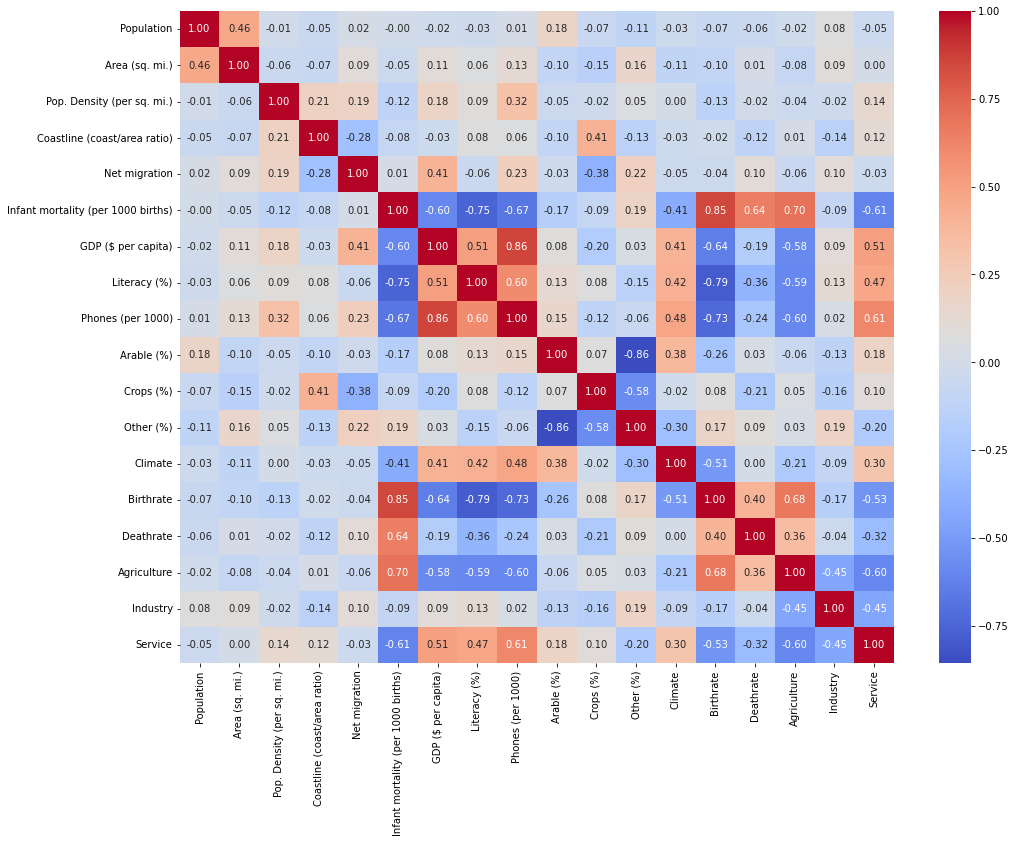

In [12]:
import seaborn as sns

plt.figure(figsize=(16,12))
sns.heatmap(data=df.iloc[:,1:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

In [13]:
num = set(df.columns.to_list()) - {'Country', 'GDP ($ per capita)', 'Climate'}

c:\Users\samuel.nporto\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\samuel.nporto\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\samuel.nporto\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

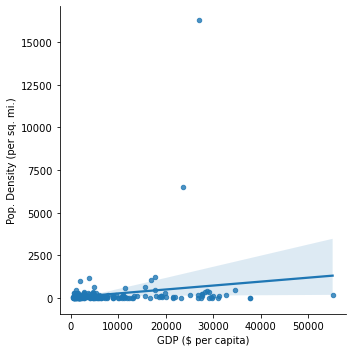

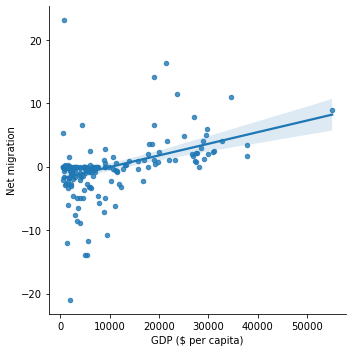

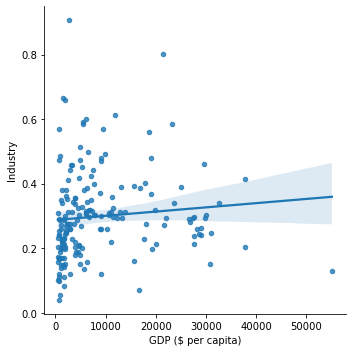

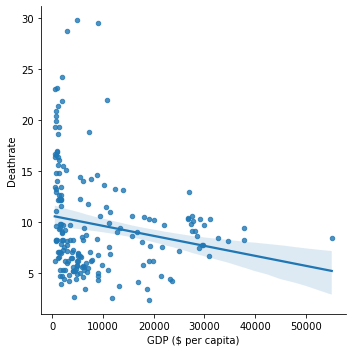

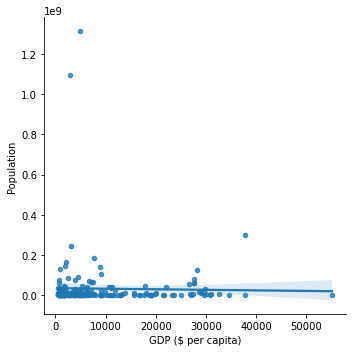

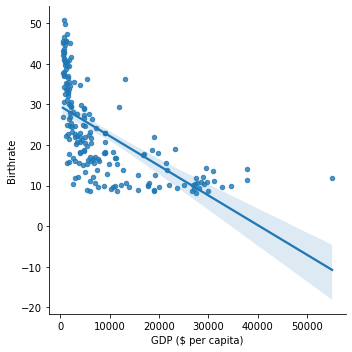

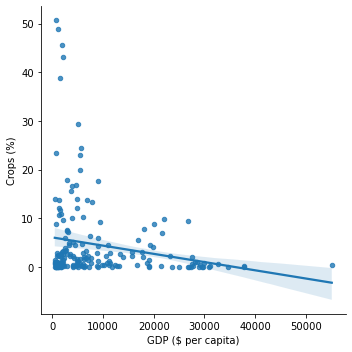

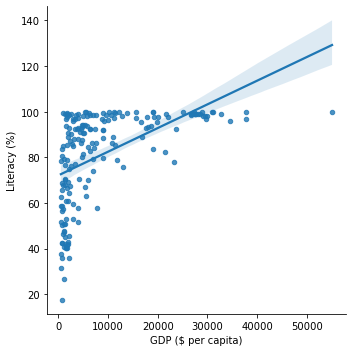

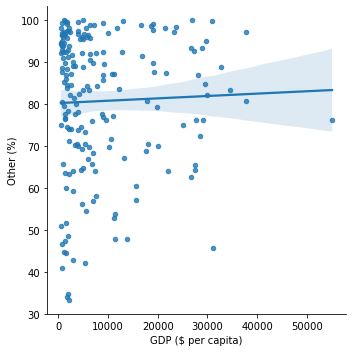

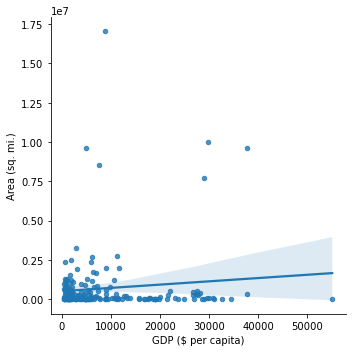

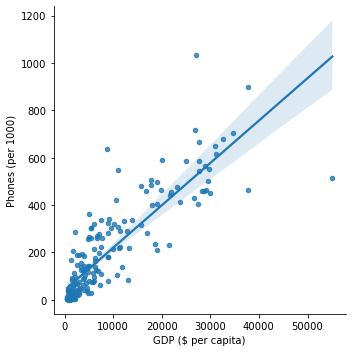

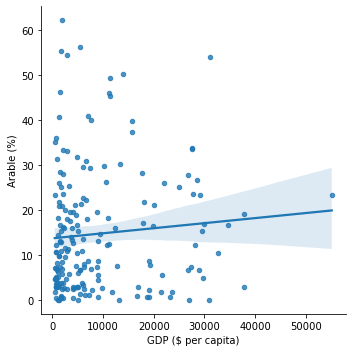

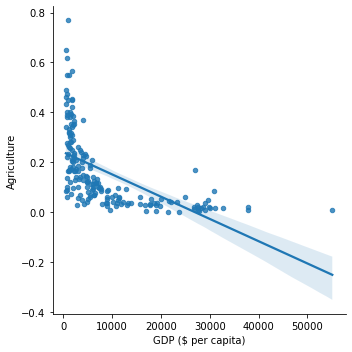

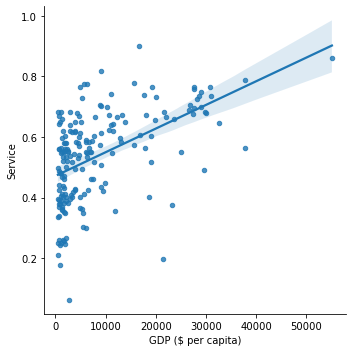

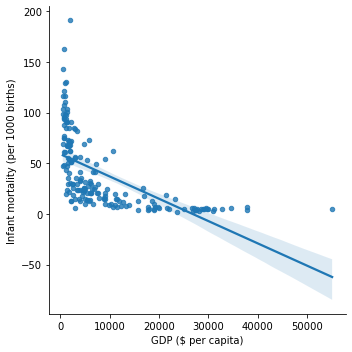

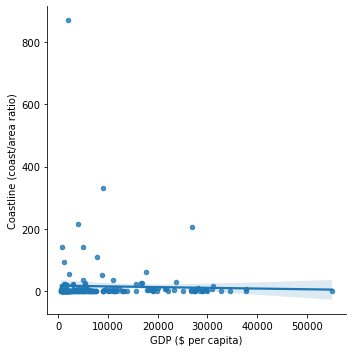

In [14]:
for n in num:
    sns.lmplot('GDP ($ per capita)', n, data=df, fit_reg=True, scatter_kws={"marker": "D", "s": 20})

array([[<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'Area (sq. mi.)'}>,
        <AxesSubplot:title={'center':'Pop. Density (per sq. mi.)'}>,
        <AxesSubplot:title={'center':'Coastline (coast/area ratio)'}>],
       [<AxesSubplot:title={'center':'Net migration'}>,
        <AxesSubplot:title={'center':'Infant mortality (per 1000 births)'}>,
        <AxesSubplot:title={'center':'GDP ($ per capita)'}>,
        <AxesSubplot:title={'center':'Literacy (%)'}>],
       [<AxesSubplot:title={'center':'Phones (per 1000)'}>,
        <AxesSubplot:title={'center':'Arable (%)'}>,
        <AxesSubplot:title={'center':'Crops (%)'}>,
        <AxesSubplot:title={'center':'Other (%)'}>],
       [<AxesSubplot:title={'center':'Climate'}>,
        <AxesSubplot:title={'center':'Birthrate'}>,
        <AxesSubplot:title={'center':'Deathrate'}>,
        <AxesSubplot:title={'center':'Agriculture'}>],
       [<AxesSubplot:title={'center':'Industry'}>,
        <AxesSubplot:

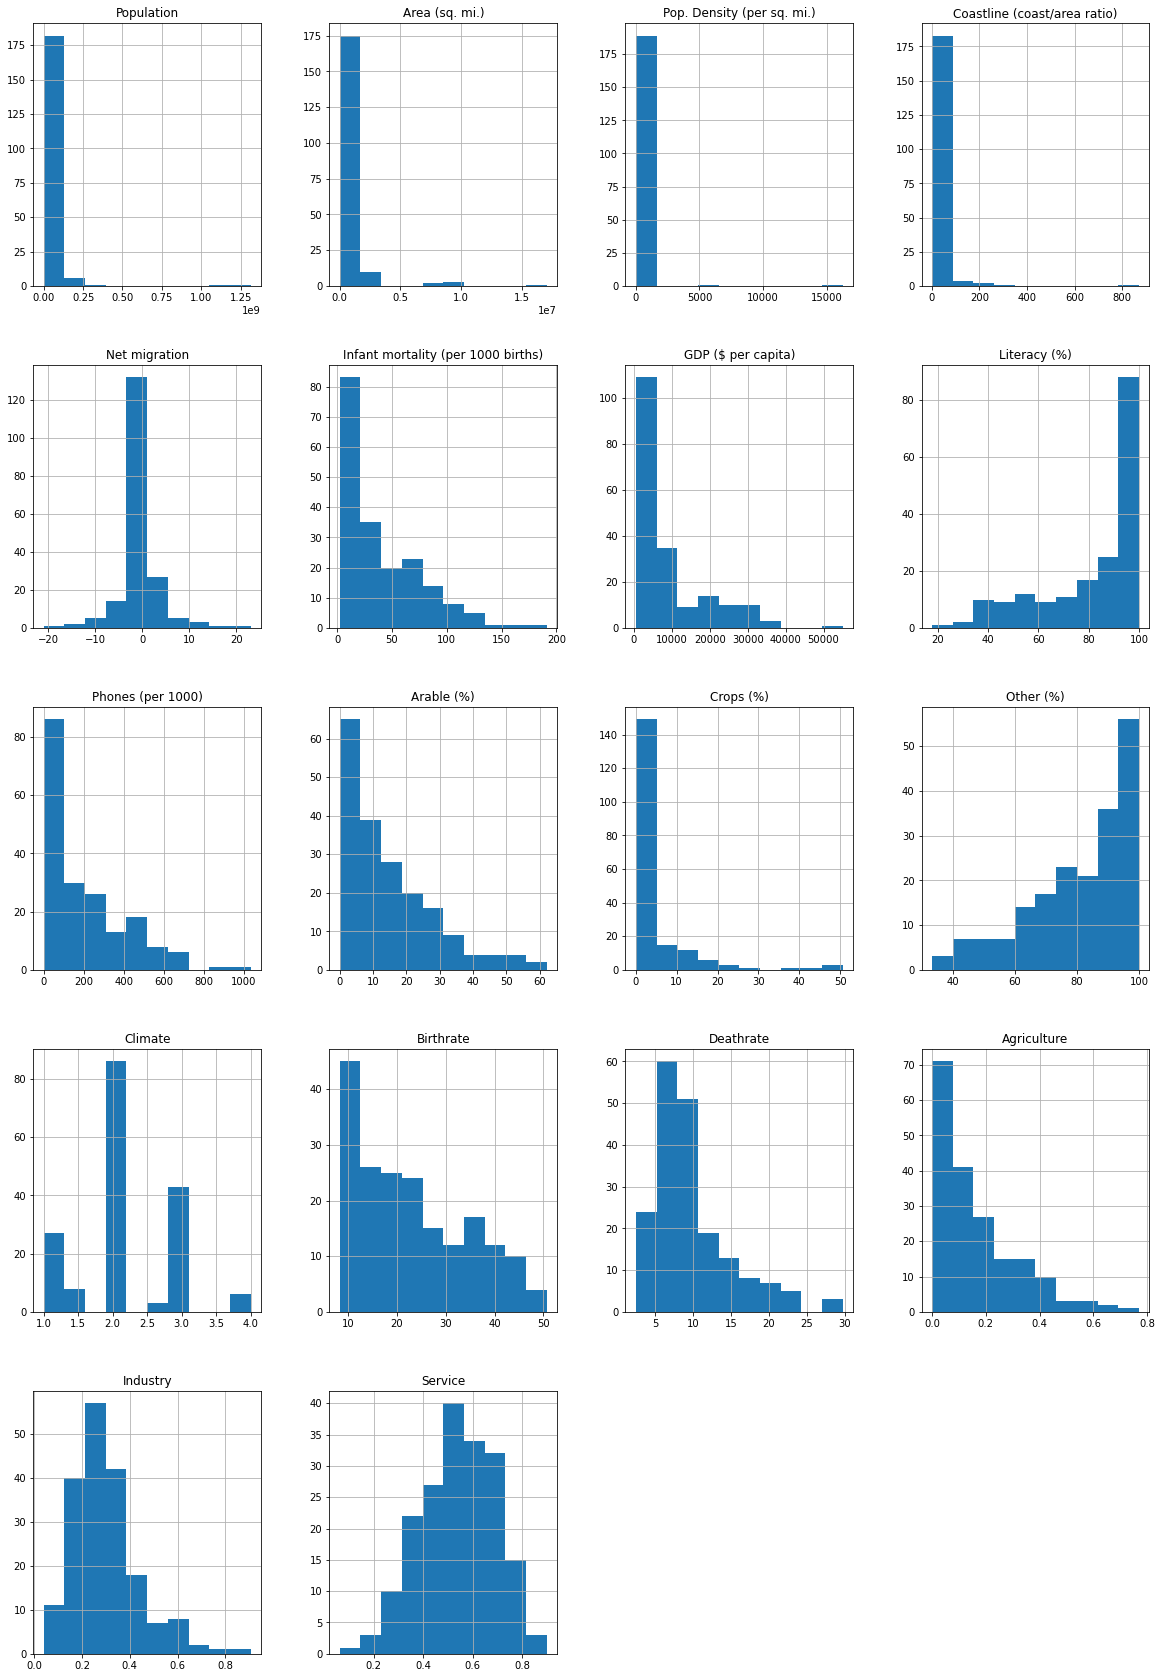

In [15]:
df.hist(figsize=(20,30))

In [16]:
df_filtered = df.copy()
df_filtered['Infant mortality (per 1000 births)'] = df['Infant mortality (per 1000 births)'].apply(np.log10)
df_filtered['GDP ($ per capita)'] = df['GDP ($ per capita)'].apply(np.log10)
df_filtered['Phones (per 1000)'] = df['Phones (per 1000)'].apply(np.log10)
# df_filtered['Arable (%)'] = df['Arable (%)'].apply(np.log10)
# df_filtered['Crops (%)'] = df['Crops (%)'].apply(np.log10)
# df_filtered['Coastline (coast/area ratio)'] = df['Coastline (coast/area ratio)'].apply(np.log10)
df_filtered['Pop. Density (per sq. mi.)'] = df['Pop. Density (per sq. mi.)'].apply(np.log10)
df_filtered['Other (%)'] = df['Other (%)'].apply(np.sqrt)
df_filtered['Literacy (%)'] = df['Literacy (%)'].apply(np.sqrt)


array([[<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'Area (sq. mi.)'}>,
        <AxesSubplot:title={'center':'Pop. Density (per sq. mi.)'}>,
        <AxesSubplot:title={'center':'Coastline (coast/area ratio)'}>],
       [<AxesSubplot:title={'center':'Net migration'}>,
        <AxesSubplot:title={'center':'Infant mortality (per 1000 births)'}>,
        <AxesSubplot:title={'center':'GDP ($ per capita)'}>,
        <AxesSubplot:title={'center':'Literacy (%)'}>],
       [<AxesSubplot:title={'center':'Phones (per 1000)'}>,
        <AxesSubplot:title={'center':'Arable (%)'}>,
        <AxesSubplot:title={'center':'Crops (%)'}>,
        <AxesSubplot:title={'center':'Other (%)'}>],
       [<AxesSubplot:title={'center':'Climate'}>,
        <AxesSubplot:title={'center':'Birthrate'}>,
        <AxesSubplot:title={'center':'Deathrate'}>,
        <AxesSubplot:title={'center':'Agriculture'}>],
       [<AxesSubplot:title={'center':'Industry'}>,
        <AxesSubplot:

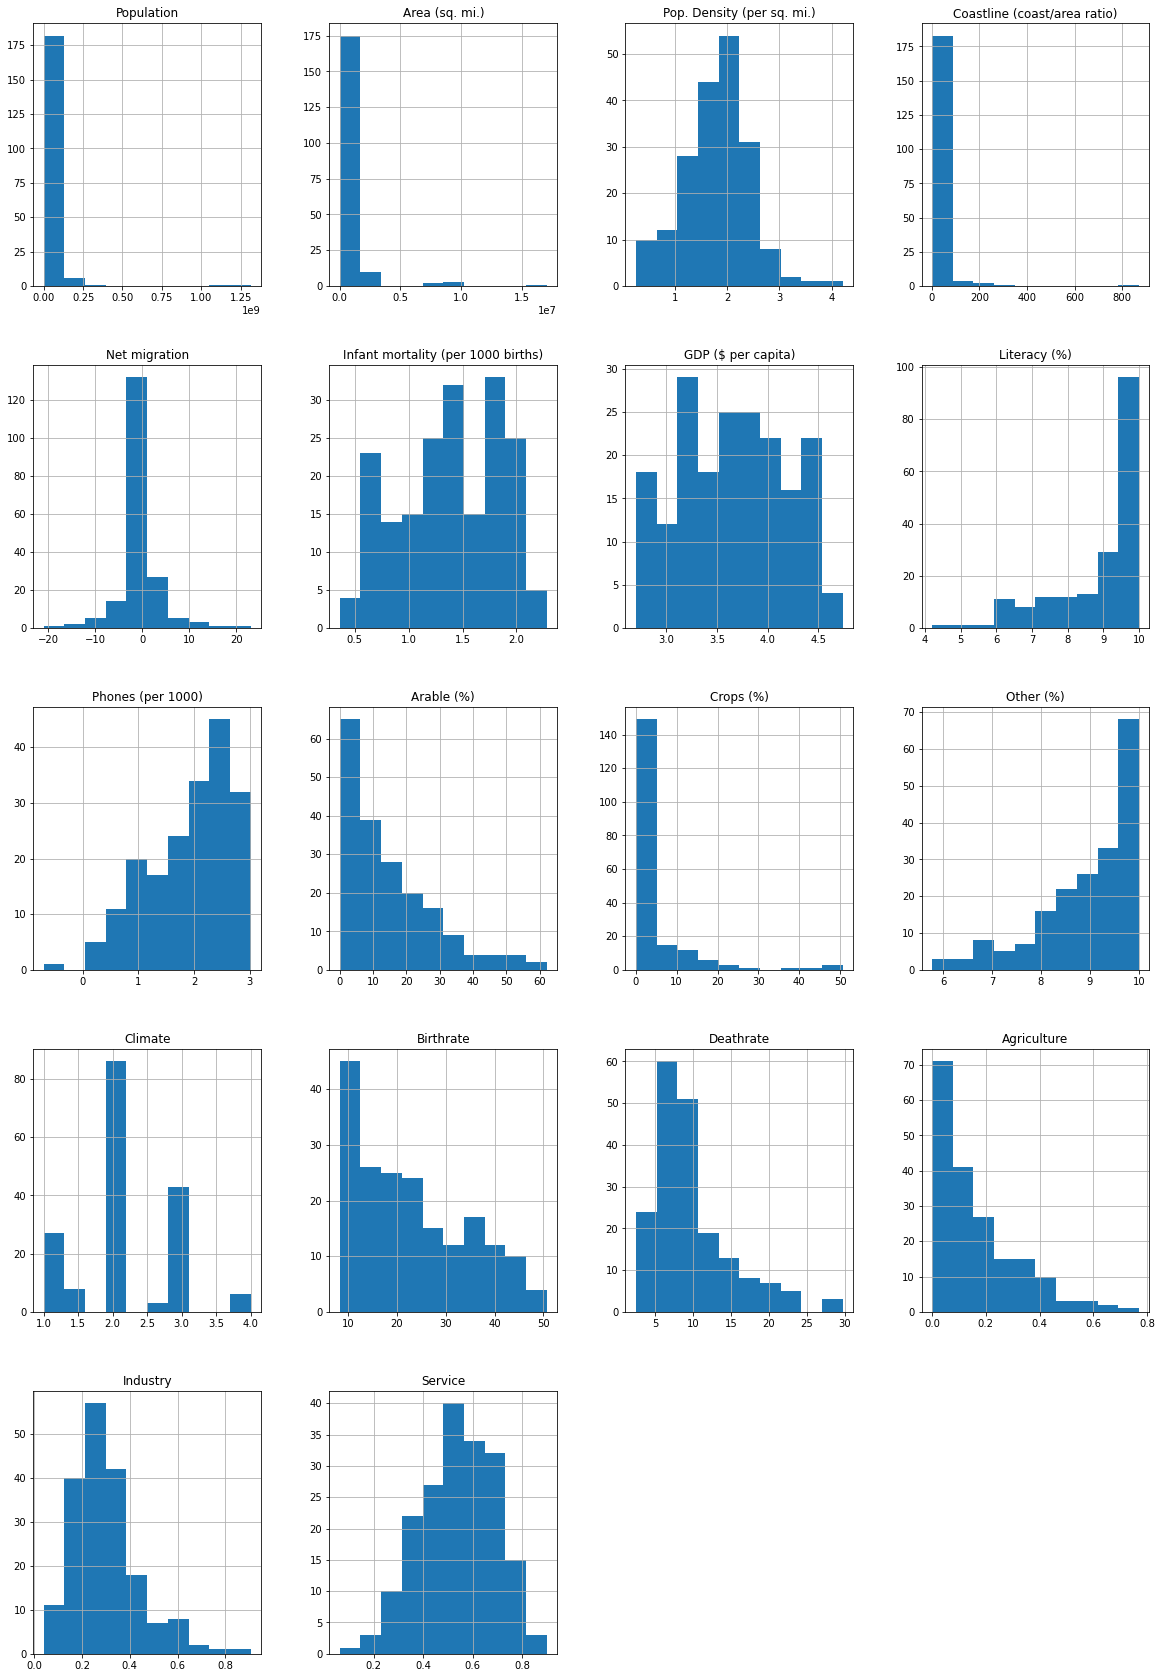

In [17]:
df_filtered.hist(figsize=(20,30))

c:\Users\samuel.nporto\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\samuel.nporto\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\samuel.nporto\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

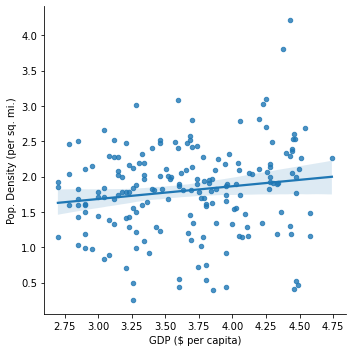

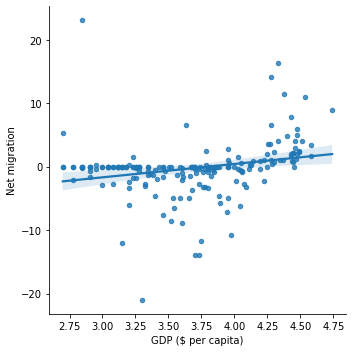

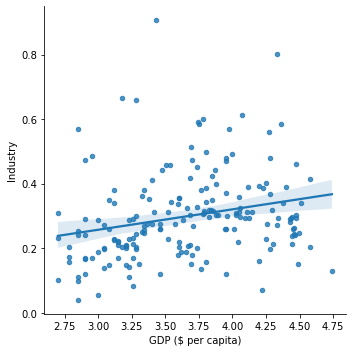

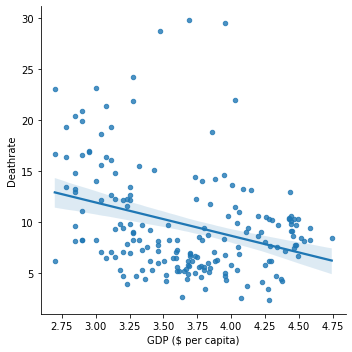

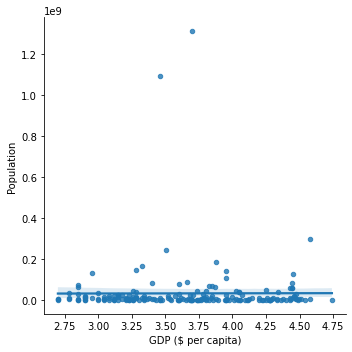

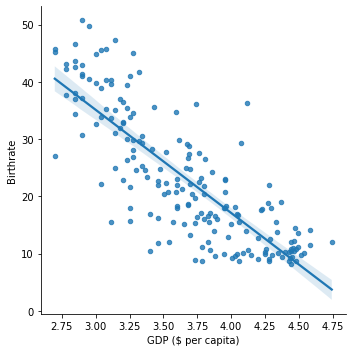

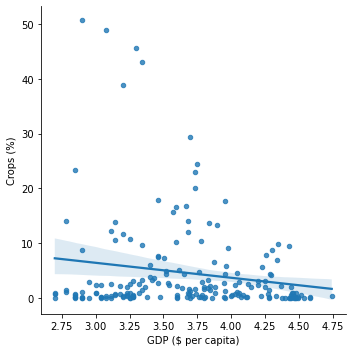

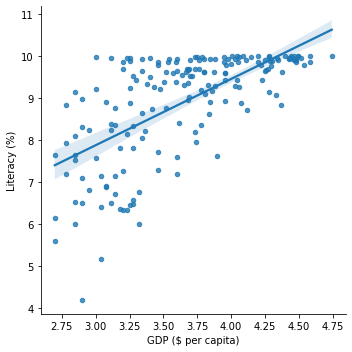

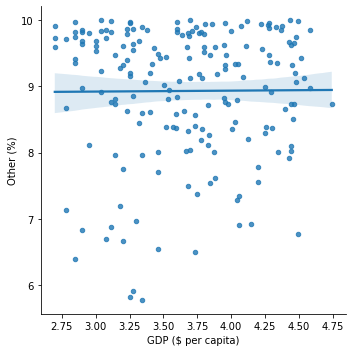

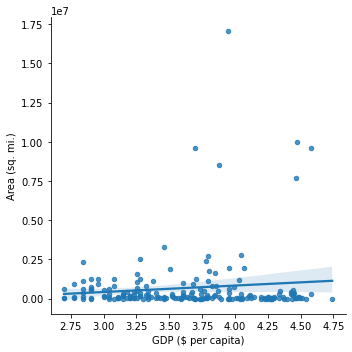

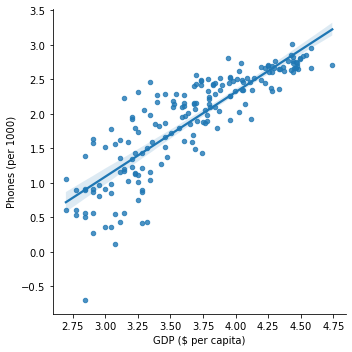

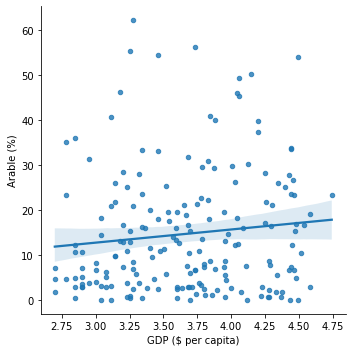

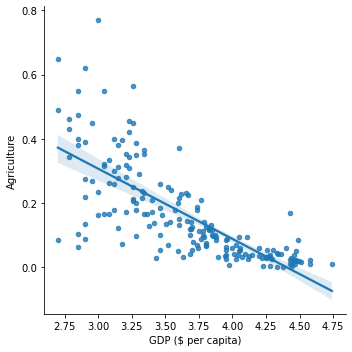

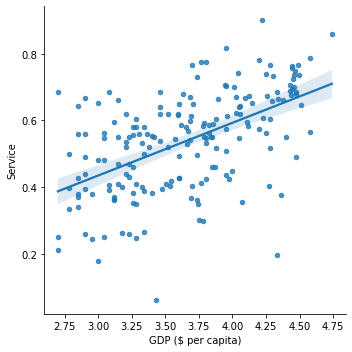

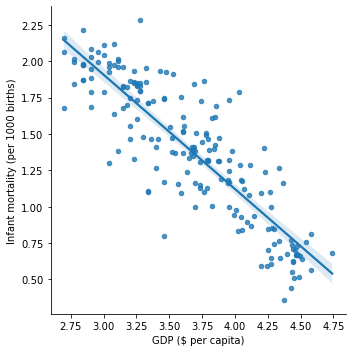

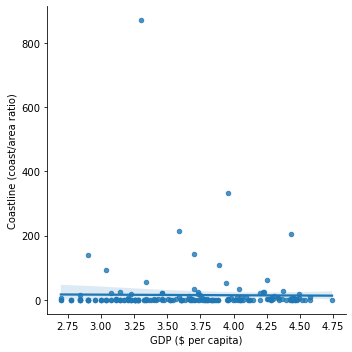

In [18]:
for n in num:
    sns.lmplot('GDP ($ per capita)', n, data=df_filtered, fit_reg=True, scatter_kws={"marker": "D", "s": 20})

<AxesSubplot:xlabel='GDP ($ per capita)'>

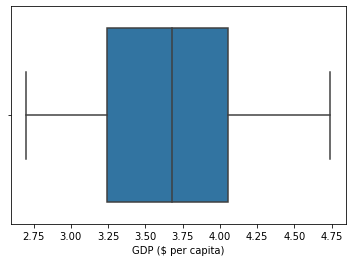

In [19]:
sns.boxplot(x=df_filtered["GDP ($ per capita)"])

In [20]:
df[df['GDP ($ per capita)'] < 2500].count()

Country                               67
Population                            67
Area (sq. mi.)                        67
Pop. Density (per sq. mi.)            67
Coastline (coast/area ratio)          67
Net migration                         67
Infant mortality (per 1000 births)    67
GDP ($ per capita)                    67
Literacy (%)                          64
Phones (per 1000)                     66
Arable (%)                            67
Crops (%)                             67
Other (%)                             67
Climate                               62
Birthrate                             66
Deathrate                             66
Agriculture                           67
Industry                              67
Service                               67
dtype: int64

In [21]:
# df_filtered['GDP ($ per capita)'] = df[df['GDP ($ per capita)'] < 2500].loc[:, 'GDP ($ per capita)']

<AxesSubplot:ylabel='Frequency'>

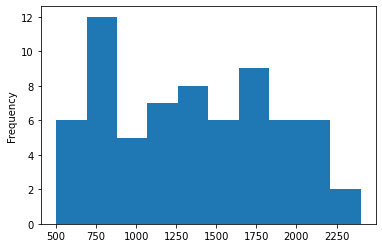

In [22]:
df[df['GDP ($ per capita)'] < 2500].loc[:, 'GDP ($ per capita)'].plot.hist()

In [23]:
df_test = df_filtered.copy()

class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T

191


,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),1.681241,2.095518,1.139879,2.182129,0.986772
Coastline (coast/area ratio),0.0,1.26,0.04,0.0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0.0
Infant mortality (per 1000 births),2.212374,1.332842,1.491362,0.607455,2.281465
GDP ($ per capita),2.845098,3.653213,3.778151,4.278754,3.278754
Literacy (%),6.0,9.300538,8.3666,10.0,6.480741
Phones (per 1000),0.50515,1.85248,1.892651,2.696531,0.892095


In [24]:
# df.isna().sum()
df_test=df_test.dropna()   ### Só para testar por enquanto


In [25]:
df_test.shape

(163, 20)

In [26]:
# ###### Pré processamento inicial (para testar o tutorial)

# df_test["Has coastline"] = df_test['Coastline (coast/area ratio)'].apply(lambda x: 0 if x == 0 else 1)

# ##### Pra esses 3 poderia pegar o maior para cada país
# # df_test["Industrial"] = df_test['Industry'].apply(lambda x: 0 if x <0.16 else 1)
# # df_test["Agricultural"] = df_test['Agriculture'].apply(lambda x: 0 if x <0.3 else 1)
# # df_test["Services"] = df_test['Service'].apply(lambda x: 0 if x <0.5 else 1)

# # df_test['Industrial']=0
# # df_test['Agricultural']=0
# # df_test['Services']=0

# df_test['Industrial'] = np.where((df_test['Agriculture'] <= df_test['Industry']) & (df_test['Service'] <= df_test['Industry']), 1,0)
# df_test['Agricultural'] = np.where((df_test['Industry'] <= df_test['Agriculture']) & (df_test['Service'] <= df_test['Agriculture']), 1,0)
# df_test['Services'] = np.where((df_test['Agriculture'] <= df_test['Service']) & (df_test['Industry'] <= df_test['Service']), 1,0)


# df_test["High Literacy"] = df_test['Literacy (%)'].apply(lambda x: 0 if x <0.9 else 1)

# ## Usar OneHotEncoder para as Climate

# # est = KBinsDiscretizer(n_bins=4, encode='ordinal', 
# #                        strategy='quantile')
# # df_test['GDP'] = est.fit_transform(df_test[['GDP ($ per capita)'])


df_test['GDP'] =df_test['GDP ($ per capita)']

#### Mudar essa classificacao para https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2020-2021

# df_test['POP_1'] = df_test['Population'].apply(lambda x: 0 if x == 0 else 1)
# df_test['POP_2']
# df_test['POP_3']
# df_test['POP_4']




df_test.drop(['GDP ($ per capita)'], axis=1, inplace=True)
df_test.T


,0,1,2,7,8,9,11,12,13,14,...,213,214,215,216,217,218,219,224,225,226
Country,Afghanistan,Albania,Algeria,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Population,31056997,3581655,32930091,69108,39921833,2976372,20264082,8192880,7961619,303770,...,60609153,298444215,3431932,27307134,208869,25730435,84402966,21456188,11502010,12236805
Area (sq. mi.),647500,28748,2381740,443,2766890,29800,7686850,83870,86600,13940,...,244820,9631420,176220,447400,12200,912050,329560,527970,752614,390580
Pop. Density (per sq. mi.),1.681241,2.095518,1.139879,2.193125,1.158362,1.999565,0.414973,1.989895,1.963316,1.338456,...,2.393751,1.491362,1.290035,1.78533,1.232996,1.450249,2.40841,1.608526,1.184691,1.495544
Coastline (coast/area ratio),0.0,1.26,0.04,34.54,0.18,0.0,0.34,0.0,0.0,25.41,...,5.08,0.21,0.37,0.0,20.72,0.31,1.05,0.36,0.0,0.0
Net migration,23.06,-4.93,-0.39,-6.15,0.61,-6.47,3.98,2.0,-4.9,-2.2,...,2.19,3.41,-0.32,-1.72,0.0,-0.04,-0.45,0.0,0.0,0.0
Infant mortality (per 1000 births),2.212374,1.332842,1.491362,1.289143,1.181272,1.366983,0.671173,0.668386,1.912435,1.401573,...,0.71265,0.812913,1.077368,1.85187,1.741624,1.346353,1.414137,1.788875,1.945912,1.830525
Literacy (%),6.0,9.300538,8.3666,9.433981,9.853933,9.929753,10.0,9.899495,9.848858,9.777525,...,9.949874,9.848858,9.899495,9.964939,7.28011,9.664368,9.502631,7.085196,8.97775,9.523655
Phones (per 1000),0.50515,1.85248,1.892651,2.740284,2.343212,2.291591,2.752433,2.655331,2.137037,2.663324,...,2.7352,2.953276,2.46449,1.798651,1.513218,2.146438,2.273464,1.570543,0.913814,1.428135
Arable (%),12.13,21.09,3.22,18.18,12.31,17.55,6.55,16.91,19.63,0.8,...,23.46,19.13,7.43,10.83,2.46,2.95,19.97,2.78,7.08,8.32


In [27]:
# df_test.drop(['Arable (%)', 'Climate', 'Service','Coastline (coast/area ratio)', 'Pop. Density (per sq. mi.)', 'Other (%)'], axis=1, inplace=True)


In [28]:
df.Population.describe()

count    1.910000e+02
mean     3.393533e+07
std      1.278974e+08
min      1.181000e+04
25%      1.640698e+06
50%      7.320815e+06
75%      2.235656e+07
max      1.313974e+09
Name: Population, dtype: float64

In [29]:
df_test.GDP


0      2.845098
1      3.653213
2      3.778151
7      4.041393
8      4.049218
         ...   
218    3.681241
219    3.397940
224    2.903090
225    2.903090
226    3.278754
Name: GDP, Length: 163, dtype: float64

In [30]:
existing_countries = df_test.Country.to_list()

In [31]:
edges = []
# src=[]
# tar=[]
for n in jdict['links']:
    if (n['source'] in existing_countries) and (n['target'] in existing_countries):
#         if n['source'] not in src:
#             src.append(n['source'])
            
#         if n['target'] not in tar:
#             tar.append(n['target'])
        edges.append((n['source'], n['target']))
df_edges= pd.DataFrame.from_records(edges, columns =['source', 'target'])
df_edges.head(5).T



,0,1,2,3,4
source,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
target,People's Republic of China,Iran,Pakistan,Tajikistan,Turkmenistan


In [32]:
df_edges.shape

(226, 2)

#### Visualizando como um grafo

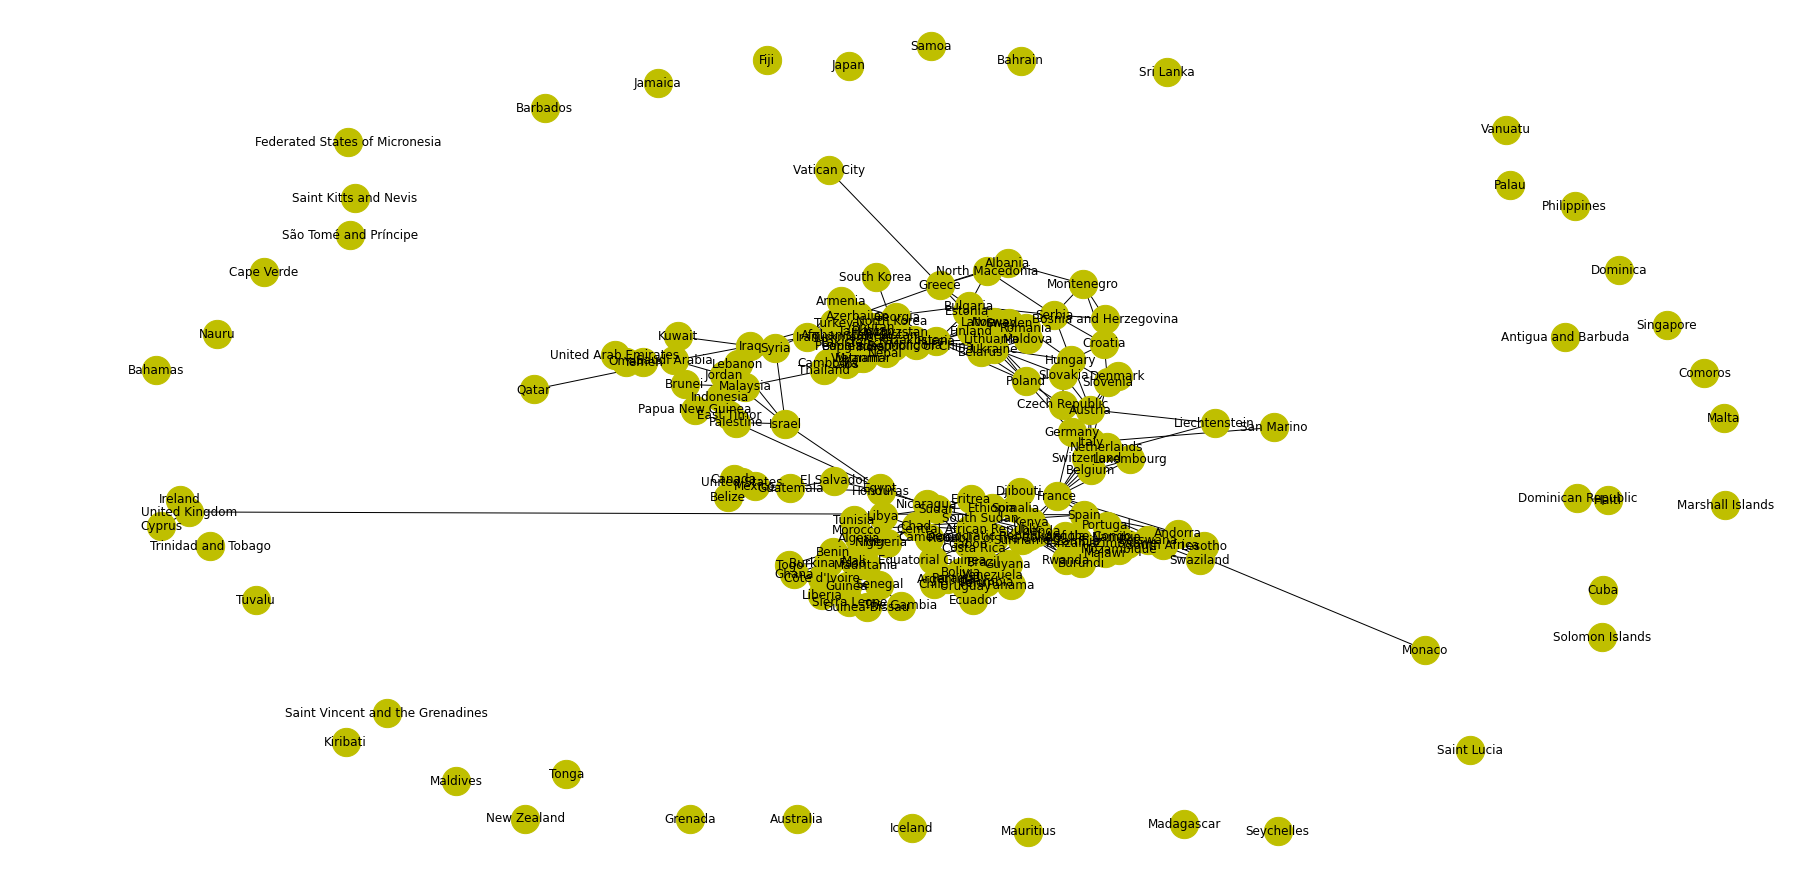

In [33]:
G = nx.Graph()
G.add_nodes_from([node['name'] for node in jdict['nodes']])
G.add_weighted_edges_from([(edge['source'], edge['target'], edge['border'])
                  for edge in jdict['links']])

pos = nx.spring_layout(G, k=.6)
plt.figure(figsize=(25,12))
nx.draw(G, 
        pos=pos,
        node_size=800, 
        with_labels=True, 
        node_color='y')
plt.show()
# plt.savefig("graph.png", dpi=1000)

#### Transformando os nodes em valores numéricos

In [34]:
class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T


163


,0,1,2,7,8
Country,Afghanistan,Albania,Algeria,Antigua and Barbuda,Argentina
Population,31056997,3581655,32930091,69108,39921833
Area (sq. mi.),647500,28748,2381740,443,2766890
Pop. Density (per sq. mi.),1.681241,2.095518,1.139879,2.193125,1.158362
Coastline (coast/area ratio),0.0,1.26,0.04,34.54,0.18
Net migration,23.06,-4.93,-0.39,-6.15,0.61
Infant mortality (per 1000 births),2.212374,1.332842,1.491362,1.289143,1.181272
Literacy (%),6.0,9.300538,8.3666,9.433981,9.853933
Phones (per 1000),0.50515,1.85248,1.892651,2.740284,2.343212
Arable (%),12.13,21.09,3.22,18.18,12.31


In [35]:
df_edges["source"] = df_edges["source"].apply(lambda name: class_idx[name])
df_edges["target"] = df_edges["target"].apply(lambda name: class_idx[name])

In [36]:
df_edges.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
source,0,0,0,0,0,0,1,2,2,2,2,4,4,4,4,4,5,5,5,5
target,111,69,106,141,149,156,57,89,91,101,147,18,20,30,110,155,8,54,69,148


# Montando o classificador
https://keras.io/examples/graph/gnn_citations/


In [37]:
feature_names = set(df_test.columns) - {"Country", "GDP", 'Country ID'}
num_features = len(feature_names)
num_classes = num_features
print(num_features, num_classes)

17 17


### Separando treino e teste

In [38]:
df_test.T

,0,1,2,7,8,9,11,12,13,14,...,213,214,215,216,217,218,219,224,225,226
Country,Afghanistan,Albania,Algeria,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Population,31056997,3581655,32930091,69108,39921833,2976372,20264082,8192880,7961619,303770,...,60609153,298444215,3431932,27307134,208869,25730435,84402966,21456188,11502010,12236805
Area (sq. mi.),647500,28748,2381740,443,2766890,29800,7686850,83870,86600,13940,...,244820,9631420,176220,447400,12200,912050,329560,527970,752614,390580
Pop. Density (per sq. mi.),1.681241,2.095518,1.139879,2.193125,1.158362,1.999565,0.414973,1.989895,1.963316,1.338456,...,2.393751,1.491362,1.290035,1.78533,1.232996,1.450249,2.40841,1.608526,1.184691,1.495544
Coastline (coast/area ratio),0.0,1.26,0.04,34.54,0.18,0.0,0.34,0.0,0.0,25.41,...,5.08,0.21,0.37,0.0,20.72,0.31,1.05,0.36,0.0,0.0
Net migration,23.06,-4.93,-0.39,-6.15,0.61,-6.47,3.98,2.0,-4.9,-2.2,...,2.19,3.41,-0.32,-1.72,0.0,-0.04,-0.45,0.0,0.0,0.0
Infant mortality (per 1000 births),2.212374,1.332842,1.491362,1.289143,1.181272,1.366983,0.671173,0.668386,1.912435,1.401573,...,0.71265,0.812913,1.077368,1.85187,1.741624,1.346353,1.414137,1.788875,1.945912,1.830525
Literacy (%),6.0,9.300538,8.3666,9.433981,9.853933,9.929753,10.0,9.899495,9.848858,9.777525,...,9.949874,9.848858,9.899495,9.964939,7.28011,9.664368,9.502631,7.085196,8.97775,9.523655
Phones (per 1000),0.50515,1.85248,1.892651,2.740284,2.343212,2.291591,2.752433,2.655331,2.137037,2.663324,...,2.7352,2.953276,2.46449,1.798651,1.513218,2.146438,2.273464,1.570543,0.913814,1.428135
Arable (%),12.13,21.09,3.22,18.18,12.31,17.55,6.55,16.91,19.63,0.8,...,23.46,19.13,7.43,10.83,2.46,2.95,19.97,2.78,7.08,8.32


In [39]:
df_test.GDP.describe()

count    163.000000
mean       3.644468
std        0.505301
min        2.698970
25%        3.230449
50%        3.662758
75%        4.035388
max        4.577492
Name: GDP, dtype: float64

In [40]:
train_data, test_data = [], []

for _, group_data in df_test.groupby("GDP"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (120, 20)
Test data shape: (43, 20)


In [41]:
# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["GDP"]
y_test = test_data["GDP"]

In [42]:
x_train.shape

(120, 17)

In [43]:
def model_predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    train_pred_Y = model.predict(x_train)
    test_pred_Y = model.predict(x_test)
    train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=y_train.index)
    test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=y_test.index)


    rmse_train = np.sqrt(mean_squared_error(train_pred_Y, y_train))
    msle_train = mean_squared_log_error(train_pred_Y, y_train)
    rmse_test = np.sqrt(mean_squared_error(test_pred_Y, y_test))
    msle_test = mean_squared_log_error(test_pred_Y, y_test)

    print('rmse_train:',rmse_train,'msle_train:',msle_train)
    print('rmse_test:',rmse_test,'msle_test:',msle_test)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [45]:
model = LinearRegression()
model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 0.1657850283374037 msle_train: 0.0013835402851842627
rmse_test: 0.2226949021840507 msle_test: 0.002590346773148962


In [46]:
model = RandomForestRegressor(n_estimators = 50,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)

model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 0.10672886325620659 msle_train: 0.0005800954362594857
rmse_test: 0.22466029738535298 msle_test: 0.0026178619223862333


In [47]:
feature_importances = (list(zip(model.feature_importances_,feature_names)))

In [48]:
sorted(feature_importances, key=lambda x: x[0], reverse=True)

[(0.4519927686920464, 'Agriculture'),
 (0.29214199982733263, 'Phones (per 1000)'),
 (0.13491087325685308, 'Infant mortality (per 1000 births)'),
 (0.07920311999513167, 'Birthrate'),
 (0.010635583183525369, 'Net migration'),
 (0.005529194499669261, 'Industry'),
 (0.004593900855468292, 'Crops (%)'),
 (0.003562589087501865, 'Literacy (%)'),
 (0.0035349497644812573, 'Area (sq. mi.)'),
 (0.002650250216951452, 'Deathrate'),
 (0.0024780168367784018, 'Service'),
 (0.001982501263058131, 'Arable (%)'),
 (0.001829975230777757, 'Other (%)'),
 (0.0017951471742169408, 'Coastline (coast/area ratio)'),
 (0.0015564975656526445, 'Pop. Density (per sq. mi.)'),
 (0.0014637110120457944, 'Population'),
 (0.0001389215385088139, 'Climate')]

In [49]:
model = DecisionTreeRegressor(max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)

model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 0.11983831551296574 msle_train: 0.0007122570938587707
rmse_test: 0.304174767530486 msle_test: 0.004527144698946334


### Testando um modelo baseline 
(Ainda não leva em consideração as conexões do grafo)

In [50]:
##  Feedforward Network (FFN) Module
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [51]:
def create_simple_model(num_classes):
    model = keras.Sequential([
        layers.Dense(1, input_shape=[num_classes]),
        #layers.Dense(5, activation='selu', input_shape=[5]),
        #layers.Dense(1),
    ])
    return model
    
baseline_model = create_simple_model(num_classes)

In [52]:

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
#     logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="baseline")


baseline_model = create_baseline_model( [32, 32], num_classes,  0.5)
baseline_model.summary()


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 17)]         0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1828        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [53]:
# def create_simple_model(num_classes, dropout_rate):
#     model = keras.Sequential([
#     layers.GaussianNoise(0.2, input_shape=[num_classes]),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(dropout_rate),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(dropout_rate),
#     layers.Dense(1)
#   ])
#     return model
    
# baseline_model = create_simple_model(num_classes, 0.2)

In [54]:
2048*2

4096

In [55]:
def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-1),
        loss='mse',
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="loss", patience=50, restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=5000,
        batch_size=2048,
        validation_split=0.2,
        callbacks=[early_stopping],

    )

    return history

In [56]:
def display_learning_curves(history):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

    ax1.plot(history.history["loss"][70:])
    ax1.plot(history.history["val_loss"][70:])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    plt.show()

In [57]:
# def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
#     inputs = layers.Input(shape=(num_features,), name="input_features")
#     x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
#     for block_idx in range(4):
#         # Create an FFN block.
#         x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
#         # Add skip connection.
#         x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
#     # Compute logits.
#     logits = layers.Dense(num_classes, name="logits")(x)
#     # Create the model.
#     return keras.Model(inputs=inputs, outputs=logits, name="baseline")


# baseline_model = create_baseline_model( [32, 32], num_classes,  0.2)
# baseline_model.summary()

In [58]:
# baseline_model = RandomForestRegressor(n_estimators = 50,
#                              max_depth = 6,
#                              min_weight_fraction_leaf = 0.05,
#                              max_features = 0.8,
#                              random_state = 42)

In [59]:
# baseline_model = create_ffn([32,32],0.2)

In [60]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/5000
1/1 [==============================] - 4s 4s/step - loss: 12.2361 - val_loss: 12.0708
Epoch 2/5000
1/1 [==============================] - 0s 29ms/step - loss: 12.2615 - val_loss: 12.0708
Epoch 3/5000
1/1 [==============================] - 0s 26ms/step - loss: 12.2872 - val_loss: 12.0708
Epoch 4/5000
1/1 [==============================] - 0s 28ms/step - loss: 12.2983 - val_loss: 12.0708
Epoch 5/5000
1/1 [==============================] - 0s 30ms/step - loss: 12.3153 - val_loss: 12.0708
Epoch 6/5000
1/1 [==============================] - 0s 28ms/step - loss: 12.3199 - val_loss: 12.0708
Epoch 7/5000
1/1 [==============================] - 0s 26ms/step - loss: 12.3204 - val_loss: 12.0708
Epoch 8/5000
1/1 [==============================] - 0s 30ms/step - loss: 12.3159 - val_loss: 12.0708
Epoch 9/5000
1/1 [==============================] - 0s 29ms/step - loss: 12.3100 - val_loss: 12.0708
Epoch 10/5000
1/1 [==============================] - 0s 30ms/step - loss: 12.3029 - val_loss:

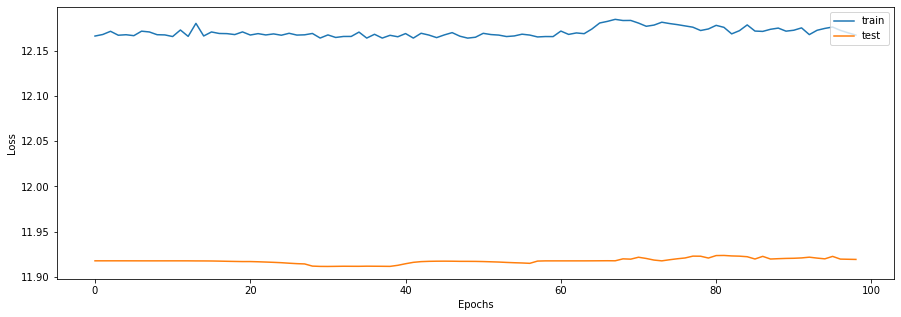

In [61]:
display_learning_curves(history)

In [62]:
original_mse = np.sqrt(baseline_model.evaluate(x=x_test, y=y_test, verbose=0))
# print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
# test_accuracy

In [63]:
original_mse

3.483461816295097

In [64]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
164,12.175069,11.919707,164
165,12.176585,11.922427,165
166,12.172912,11.919415,166
167,12.170155,11.919231,167
168,12.167682,11.919060,168


In [65]:
list(zip(baseline_model(x_test).numpy()[:,0], y_test))

[(0.19762945, 4.442479769064448),
 (0.19762945, 4.492760389026838),
 (0.19762945, 3.8808135922807914),
 (0.19762945, 3.255272505103306),
 (0.19762945, 3.6989700043360187),
 (0.19762945, 3.322219294733919),
 (0.19762945, 3.7634279935629373),
 (0.19762945, 3.9590413923210934),
 (0.19762945, 3.462397997898956),
 (0.19762945, 4.071882007306125),
 (0.19762945, 4.463892988985907),
 (0.19762945, 3.845098040014257),
 (0.19762945, 3.278753600952829),
 (0.19762945, 3.4149733479708178),
 (0.19762945, 2.9030899869919438),
 (0.19762945, 2.6989700043360187),
 (0.19762945, 2.7781512503836434),
 (0.19762945, 2.845098040014257),
 (0.19762945, 3.7323937598229686),
 (0.19762945, 4.301029995663981),
 (0.19762945, 2.9030899869919438),
 (0.19762945, 3.681241237375587),
 (0.19762945, 4.278753600952829),
 (0.19762945, 3.9777236052888476),
 (0.19762945, 3.380211241711606),
 (0.19762945, 4.471291711058939),
 (0.19762945, 3.230448921378274),
 (0.19762945, 3.7634279935629373),
 (0.19762945, 2.845098040014257),
 (

### Modelo GNN - que considera os grafos

In [66]:
DROPOUT_RATE  =0.2

In [67]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=DROPOUT_RATE,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)


In [68]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=DROPOUT_RATE,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)


#### Preparação dos dados

In [69]:
edges = df_edges[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df_test.sort_values("Country")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

In [70]:
graph_info = (node_features, edges, edge_weights)
print("Node features shape:", node_features.shape)
print("Edges shape:", edges.shape)
print("edge_weights shape:", edge_weights.shape)

Node features shape: (163, 17)
Edges shape: (2, 226)
edge_weights shape: (226,)


#### Instanciando o modelo

In [71]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[32, 32],
    dropout_rate=DROPOUT_RATE,
    name="gnn_model",
)


In [72]:
gnn_model([1,10])

<tf.Tensor: shape=(2, 17), dtype=float32, numpy=
array([[ 365946.75   , -228952.97   ,  -68330.33   ,   14340.197  ,
         193524.25   ,  -71918.87   ,  100805.375  ,   90177.39   ,
          19128.184  ,   -6172.203  ,  120761.73   ,  180690.08   ,
        -223288.56   ,  -46964.18   , -195830.95   , -102020.06   ,
        -185776.94   ],
       [  71789.75   ,  -45163.242  ,  -13778.385  ,    2443.7268 ,
          37799.66   ,  -13982.086  ,   20047.695  ,   17592.398  ,
           3623.1396 ,    -803.51953,   23615.031  ,   35676.664  ,
         -43549.85   ,   -9122.137  ,  -38164.625  ,  -19929.504  ,
         -36906.285  ]], dtype=float32)>

In [73]:
gnn_model.summary()

Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (163, 32)                 1828      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (163, 32)                 2368      
                                                                 
 logits (Dense)              multiple                  561       
                                                                 
Total params: 16,533
Trainable params: 15,667
Non-trainab

In [74]:
x_train = train_data['Country ID'].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/5000
1/1 [==============================] - 4s 4s/step - loss: 13.9833 - val_loss: 11.0421
Epoch 2/5000
1/1 [==============================] - 0s 37ms/step - loss: 4.9506 - val_loss: 13.1387
Epoch 3/5000
1/1 [==============================] - 0s 26ms/step - loss: 21.3661 - val_loss: 61.9921
Epoch 4/5000
1/1 [==============================] - 0s 34ms/step - loss: 2.4828 - val_loss: 180.2953
Epoch 5/5000
1/1 [==============================] - 0s 30ms/step - loss: 5.9961 - val_loss: 113.2617
Epoch 6/5000
1/1 [==============================] - 0s 29ms/step - loss: 5.6183 - val_loss: 72.0587
Epoch 7/5000
1/1 [==============================] - 0s 29ms/step - loss: 4.7309 - val_loss: 84.7720
Epoch 8/5000
1/1 [==============================] - 0s 32ms/step - loss: 2.5357 - val_loss: 133.8573
Epoch 9/5000
1/1 [==============================] - 0s 39ms/step - loss: 2.1952 - val_loss: 137.1737
Epoch 10/5000
1/1 [==============================] - 0s 30ms/step - loss: 2.2391 - val_loss: 88.

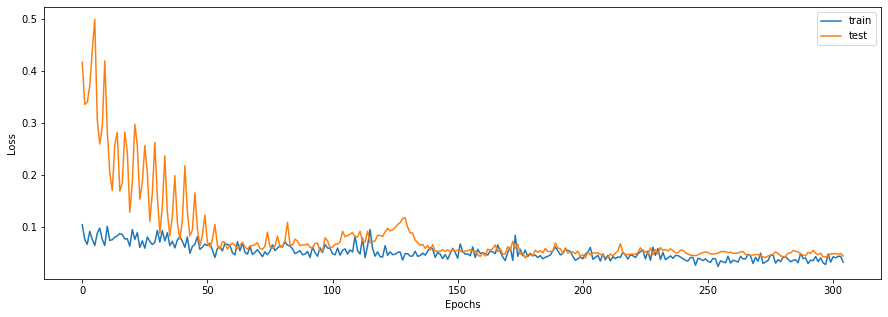

In [75]:
display_learning_curves(history)

In [76]:
x_test = test_data['Country ID'].to_numpy()

In [77]:
mse_train = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
print(np.sqrt(mse_train))


0.15296114626018342


In [78]:
mse_test = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(np.sqrt(mse_test))

0.24178861255733924


In [79]:
original_mse/np.sqrt(mse_test)

14.40705490408076

In [80]:
list(zip(gnn_model(x_train).numpy()[:,0], y_train))

[(4.4203634, 4.4623979978989565),
 (4.1362867, 4.107209969647869),
 (3.1455112, 3.2041199826559246),
 (3.5791235, 3.591064607026499),
 (3.1006784, 3.113943352306837),
 (3.6784496, 3.5440680443502757),
 (4.383956, 4.334453751150931),
 (3.9931364, 3.9542425094393248),
 (3.6656733, 3.6532125137753435),
 (3.718412, 3.838849090737255),
 (3.9472952, 3.9444826721501687),
 (3.1490626, 3.0791812460476247),
 (3.8628802, 3.7993405494535817),
 (3.6917882, 3.3979400086720375),
 (3.2318993, 3.0),
 (3.6818595, 3.3979400086720375),
 (3.2253375, 3.342422680822206),
 (3.0570812, 3.041392685158225),
 (3.6241693, 3.6020599913279625),
 (4.4338408, 4.514547752660286),
 (3.2141938, 3.462397997898956),
 (3.115263, 3.230448921378274),
 (3.1411414, 3.2041199826559246),
 (4.285424, 4.296665190261531),
 (3.0372133, 3.041392685158225),
 (3.6858797, 3.568201724066995),
 (3.0367475, 2.9030899869919438),
 (3.8355079, 3.8808135922807914),
 (4.2037983, 4.222716471147583),
 (3.8982449, 4.056904851336473),
 (4.2592754, 4

In [81]:
list(zip(gnn_model(x_test).numpy()[:,0], y_test))

[(4.3708596, 4.442479769064448),
 (4.195791, 4.492760389026838),
 (3.8473535, 3.8808135922807914),
 (3.072444, 3.255272505103306),
 (3.649321, 3.6989700043360187),
 (3.2218556, 3.322219294733919),
 (3.7476082, 3.7634279935629373),
 (4.2036176, 3.9590413923210934),
 (3.7108016, 3.462397997898956),
 (4.100722, 4.071882007306125),
 (4.3557982, 4.463892988985907),
 (3.7475753, 3.845098040014257),
 (3.1401644, 3.278753600952829),
 (3.5479975, 3.4149733479708178),
 (3.1412292, 2.9030899869919438),
 (2.9759908, 2.6989700043360187),
 (3.077148, 2.7781512503836434),
 (3.0142493, 2.845098040014257),
 (3.6225595, 3.7323937598229686),
 (4.282948, 4.301029995663981),
 (3.2035956, 2.9030899869919438),
 (3.9629006, 3.681241237375587),
 (4.451367, 4.278753600952829),
 (3.641223, 3.9777236052888476),
 (3.5244303, 3.380211241711606),
 (4.3907676, 4.471291711058939),
 (3.1190524, 3.230448921378274),
 (3.343193, 3.7634279935629373),
 (3.17689, 2.845098040014257),
 (3.846253, 3.4313637641589874),
 (3.15653